In [1]:
# config.py
import config
import matplotlib.pyplot as plt

## 모듈 준비

### Hugging Face Login

In [2]:
!mkdir -p ~/.huggingface
!echo -n "{config.HUGGINGFACE_TOKEN}" > ~/.huggingface/token

### Diffusers 설치

In [3]:
!git clone https://github.com/huggingface/diffusers ./diffusers_git

Cloning into './diffusers_git'...
remote: Enumerating objects: 66263, done.
remote: Counting objects: 100% (15931/15931), done.
remote: Compressing objects: 100% (1929/1929), done.
remote: Total 66263 (delta 15015), reused 14190 (delta 13912), pack-reused 50332
Receiving objects: 100% (66263/66263), 46.13 MiB | 33.38 MiB/s, done.
Resolving deltas: 100% (49186/49186), done.


In [4]:
!cd diffusers_git && git checkout tags/v0.22.0

Note: switching to 'tags/v0.22.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at df60b35e4 Release: v0.22.0


In [5]:
!pip install -e ./diffusers_git

Obtaining file:///aiffel/aiffel/Study/0723/diffusers_git
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     |████████████████████████████████| 417 kB 6.0 MB/s            
     |████████████████████████████████| 1.2 MB 57.3 MB/s            
     |████████████████████████████████| 177 kB 80.7 MB/s            
  Building editable for diffusers (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.22.0-0.editable-py3-none-any.whl size=10566 sha256=d7b577b0ce2b67b0359aa806f9e7b60685090cf73b1bfa08da209804f0cd9f9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-maxs0dyc/wheels/0e/48/fc/91e5e2366140e9fedf8876a94d57a85f45eed948c367f76387
Successfully built diffusers
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2021.11.1
    Uninstalling fsspec-2021.11.1:
      Successfully uninstalled

In [6]:
!pip list | grep diffusers

diffusers                     0.22.0             /aiffel/aiffel/Study/0723/diffusers_git


### 의존성 설치

In [7]:
# torchvision==0.16.1로 text 수정
!sed -i 's/torchvision/torchvision==0.16.1/g' ./diffusers_git/examples/dreambooth/requirements.txt

In [8]:
# requirements -> torchvision==0.16.1
!pip install -r ./diffusers_git/examples/dreambooth/requirements.txt
!pip uninstall -y bitsandbytes
!pip install bitsandbytes==0.41.1
!pip install xformers==0.0.20
!pip install accelerate==0.24.1
!pip install triton==2.0.0

     |████████████████████████████████| 315 kB 4.9 MB/s            
     |████████████████████████████████| 6.8 MB 66.4 MB/s            
     |████████████████████████████████| 9.4 MB 75.8 MB/s            
     |████████████████████████████████| 54 kB 5.9 MB/s             
     |████████████████████████████████| 4.5 MB 67.9 MB/s            
     |████████████████████████████████| 670.2 MB 6.5 kB/s              
     |████████████████████████████████| 23.7 MB 65.9 MB/s            
     |████████████████████████████████| 823 kB 53.3 MB/s            
     |████████████████████████████████| 6.2 MB 56.4 MB/s            
     |████████████████████████████████| 121.6 MB 31 kB/s              
     |████████████████████████████████| 410.6 MB 2.6 kB/s              
     |████████████████████████████████| 56.5 MB 26 kB/s              
     |████████████████████████████████| 14.1 MB 74 kB/s              
     |████████████████████████████████| 731.7 MB 6.6 kB/s              
     |████████████████

In [9]:
# acclerate 모듈의 config 초기화
!accelerate config default

accelerate configuration saved at /aiffel/.cache/huggingface/accelerate/default_config.yaml


## Dreambooth

### 데이터
- Unique class: 학습 시키려는 예시를 포괄하는 dog, person 등의 중간 카테고리로 클래스를 설정해줍니다. 우리는 dog 를 사용하도록 하겠습니다.

- Unique identifier: 학습 시키고싶은 특정한 대상을 위해, 이전 어휘와 겹치지않는 유일한 단어를 identifier, ID 로 설정해줍니다. 이때 아무 의미를 지니지 않은 무작위의 단어 조합을 선택하도록합니다. 이 예시에서는 **sks** 와 같이 최대한 아무 의미를 가지지 않는 단어를 사용했습니다.

- Class prompt: 특정한 ID 를 제외하고 이미지에 대한 설명을 넣어주도록 합니다. "a photo of dog".

- Instance prompt: 학습시킬 대상 이미지들이 표기되어있는 설명 문장을 입력합니다. 예시로 다음과 같은 형식을 사용할 수 있습니다 - f"a photo of {unique_id} {unique_class}". 예제에서 사용할 ID 와 클래스를 조합하면 "a photo of sks dog" 와 같은 문장을 만들 수 있습니다.

- Class images: class prompt 에 맞추어 학습시킬 대상을 포함하는 넓은 범위의 이미지를 모읍니다. 일반적으로 200-300 장 정도면 충분합니다.

- Instance images: instance prompt 와 연결하여 학습할 수 있는 이미지를 모읍니다. 학습시키고싶은 동일한 대상으로 3 - 5 장 만 마련하면 됩니다.

In [10]:
from huggingface_hub import snapshot_download

# dog image
local_dir = "./diffusers_git/examples/dreambooth/dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

alvan-nee-Id1DBHv4fbg-unsplash.jpeg:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

alvan-nee-bQaAJCbNq3g-unsplash.jpeg:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

alvan-nee-9M0tSjb-cpA-unsplash.jpeg:   0%|          | 0.00/677k [00:00<?, ?B/s]

alvan-nee-eoqnr8ikwFE-unsplash.jpeg:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

alvan-nee-brFsZ7qszSY-unsplash.jpeg:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

'/aiffel/aiffel/Study/0723/diffusers_git/examples/dreambooth/dog'

In [11]:
# .cache 삭제
!rm -rf ./diffusers_git/examples/dreambooth/dog/.cache

In [12]:
%reset -f

!sh train_dreambooth.sh

print('----'*64)
print('학습 완료!!')

CompVis/stable-diffusion-v1-4
/opt/conda/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
07/23/2024 19:23:34 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

tokenizer/tokenizer_config.json: 100%|██████████| 806/806 [00:00<00:00, 101kB/s]
tokenizer/vocab.json: 100%|████████████████| 1.06M/1.06M [00:00<00:00, 18.0MB/s]
tokenizer/merges.txt: 100%|██████████████████| 525k/525k [00:00<00:00, 4.20MB/s]
text_encoder/config.json: 100%|█████████████████| 592/592 [00:00<00:00, 135kB/

### Inference with ckeckpoints

In [14]:
%reset -f

# 의존성 모듈을 삭제 후 다시 설치합니다.
!pip uninstall -y diffusers
!pip install diffusers==0.22.0
!pip install Pillow==9.0.0

from diffusers import DiffusionPipeline, UNet2DConditionModel
from transformers import CLIPTextModel
import torch

# huggingface에 미리 등록된 base 모델을 다운로드하여 사용합니다.
model_id = "CompVis/stable-diffusion-v1-4"

# 앞서 학습 코드로 만들어진 파라미터들을 로드합니다.
unet = UNet2DConditionModel.from_pretrained("./diffusers_git/examples/dreambooth/data/unet")
text_encoder = CLIPTextModel.from_pretrained("./diffusers_git/examples/dreambooth/data/text_encoder")

# stable diffusion 의 전체 파이프라인을 구성해줍니다.
pipeline = DiffusionPipeline.from_pretrained(model_id, unet=unet, text_encoder=text_encoder, dtype=torch.float16)
pipeline.to("cuda")

Found existing installation: diffusers 0.22.0
Uninstalling diffusers-0.22.0:
  Successfully uninstalled diffusers-0.22.0
  Using cached diffusers-0.22.0-py3-none-any.whl (1.7 MB)


/opt/conda/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.22.0",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

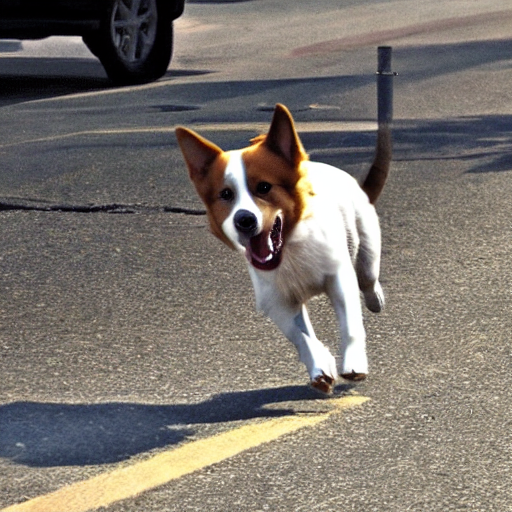

In [15]:
prompt = "A photo of sks dog chasing a car"
image = pipeline(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

image.save("dog-bucket.png")
image

### Dreambooth 를 사용할 때 주의할 점

- 드림부스는 상당히 빠르게 과적합하는 경향이 있습니다. 양질의 이미지를 생성하려면 훈련의 스텝 수와 학습률 사이의 '스윗 스팟'을 찾아야 합니다. 낮은 학습률을 먼저 사용하고, 결과가 만족스러울 때까지 단계의 수를 점진적으로 늘리는 것이 좋습니다.

- 드림부스로 얼굴을 학습하기 위해서는 보통 더 많은 훈련 단계가 필요합니다. 실험에서, 800-1200 스텝으로 배치 사이즈 2 와 1e-6의 학습률을 사용할 때 잘 작동했다는 기록이 있습니다.

- 얼굴을 훈련할 때 과적합을 피하기 위해 Class image 를 활용한 사전 보존 prior_preservationpreservation 이 중요합니다. 다른 종류의 형상의 경우, 큰 차이를 보이지는 않습니다.

- 생성된 이미지에 노이즈가 많거나 품질이 저하된다면, 과적합이 발생했다는 의미일 가능성이 높습니다. 과적합을 피하기 위해 더 많은 추론 스텝을 실행해보세요(~100 스텝까지는 실험에서 잘 작동했습니다).

- Unet 에 더해줄 텍스트 인코더를 학습시키는 것이 생성 결과물을 크게 향상 시킬 수 있습니다. 하지만 텍스트 인코더를 미세조정하기 위해서는 24 GB 이상의 GPU 메모리를 안정적으로 확보할 수 있어야합니다. 메모리가 상대적으로 부족한 시스템이라면 8-bit adam, fp16(float-point 16) 학습, 그래디언트 축적 등의 기법을 추가하여 16 GB 정도의 GPU로도 학습이 가능할 수 있습니다.

- Dreambooth 의 초기 구현 방법에서 알려진 것과는 다르게, 프롬프트로 sks 와 같이 고유한 키워드를 꼭 설정해줄 필요는 없다는 것이 밝혀졌습니다. 타겟 대상을 가리키는 평이한 단어만으로도 미세조정을 충분히 수행할 수 있다고 알려졌습니다.